# Solving the diffusion equation

In [1]:
# Imports relevant modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
from time import time
from numba import njit

In [2]:
# Defines constants
morphogenLeftConc = 0 # 1
morphogenInput = 1
d = 0.93
numOfSnapshots = 10

Equation to solve:
$$\frac{dg}{dt} = D \frac{\partial^2g}{\partial x^2} + M - \lambda g$$

Should have solution of the form $g = A e^{-x/\kappa} \,\,;\, \kappa = \sqrt{\frac{D}{\lambda}}$ in the steady state.

Discretising:
$$\frac{g_{i,n+1} - g_{i,n}}{\Delta t} = D\frac{g_{i+1,n} - 2g_{i,n} + g_{i-1,n}}{(\Delta x)^2} + M - \lambda g_{i,n}$$
$$g_{i,n+1} = g_{i,n}(1 - \frac{2D\Delta t}{(\Delta x)^2} - \lambda \Delta t) + \frac{D\Delta t}{(\Delta x)^2} (g_{i+1,n} + g_{i-1,n}) + M\Delta t$$

In [6]:
def exponential(x, A, kappa):
    """
    Creates an arbitrary exponential function.
    
    Inputs:
        - x:np.ndarray: Positions to evaluate the exponential at.
        - A:float: Leading coefficient.
        - kappa:float: Decay constant.
    
    Outputs:
        - y:np.ndarray: Evaluated exponential.
    """
    
    y = A*np.exp(-x/kappa)
    
    return y

@njit
def finiteDifferenceSolve(concInitial:np.ndarray, Nspace:int, Nsteps:int,
                          dx:float, dt:float, diffConst:float,
                          decayConst:float, numOfSnapshots:int,
                          snapshotPeriod:int) -> np.ndarray:
    """
    Solve the diffusion equation with a finite differences approach.
    Save only numOfSnapshots snapshots
    
    Inputs:
        - concInitial:np.ndarray: Initial concentration profile.
        - Nspace:int: Spatial points.
        - Nsteps:int: Number of time steps.
        - dx:float: Spatial separation.
        - dt:float: Time step.
        - diffConst: Diffusion coefficient.
        - decayConst: Degregation constant.
        - numOfSnapshots:int: The number of samples to take.
        - snapshotPeriod:int: Steps separating the snapshots.
        
    Outputs:
        - concHistory:np.ndarray: The concentration profile at different snapshots.
    """
    
    concHistory = np.zeros((numOfSnapshots, Nspace))

    
    # Creates two arrays to alternate between.
    concEven = concInitial
    concOdd = np.empty(Nspace)
    
    for n in range(1, Nsteps-1):
        for i in range(1, Nspace-1):
            if n%2 == 0:
                concEven[i] = (concOdd[i]*(1 - 2*diffConst*dt/dx**2 - decayConst*dt) 
                                + diffConst*dt/dx**2 * (concOdd[i+1] + concOdd[i-1]) 
                                + morphogenLeftConc*d**(i*dx)*dt)
                # No flux boundary conditions
                concEven[0] = concEven[1] + dx*morphogenInput
                concEven[-1] = concEven[-2]
                
            elif n%2 == 1:
                concOdd[i] = (concEven[i]*(1 - 2*diffConst*dt/dx**2 - decayConst*dt) 
                                + diffConst*dt/dx**2 * (concEven[i+1] + concEven[i-1]) 
                                + morphogenLeftConc*d**(i*dx)*dt)
                # No flux boundary conditions
                concOdd[0] = concOdd[1] + dx*morphogenInput
                concOdd[-1] = concOdd[-2]

            
            # Save the current concentration profile
            if n % snapshotPeriod == 0:
                concHistory[int(n/snapshotPeriod)] = concEven if n%2==0 else concOdd
        
            
        # Progress bar
        if (n+2) % int(Nsteps/10) == 0:
            print('Progress: ' + str(int(100*(n+2)/Nsteps)) + '%')
        
        
    return concHistory


def compareToExpectation(xPoints:np.ndarray, finalConc:np.ndarray,
                         diffConst:float, decayConst:float) -> np.ndarray:
    """
    Attempts to fit an exponential to the data.
    
    Inputs:
        - xPoints:np.ndarray: An array of possible x positions.
        - finalConc:np.ndarray: An array of the final concentration profile.
        - diffConst:float: Diffusion coefficient.
        - decayConst:float: Degregation constant.
    
    Ouputs:
        - variables:np.ndarray: Array with two elements corresponding
                                to the parameters defining the exponential.
    """
    
    # Fits concentration profile to the exponential
    variables, cvm = spo.curve_fit(exponential, xPoints, finalConc)
    
    # Obtains uncertainties for the parameters
    U_var = [np.sqrt(cvm[i,i]) for i in range(2)] 
    
    print(f'kappa: \n\t Fitted: {variables[1]} +/- {U_var[1]} ' 
          + f'\n\t Calculated: {np.sqrt(diffConst/decayConst)} = sqrt({diffConst}/{decayConst})')
    
    return variables
    


def displayConcHistory(xPoints:np.ndarray, concHistory:np.ndarray, Nspace:int, Nsteps:int,
                          dx:float, dt:float, numOfSnapshots:int, variables:np.ndarray, snapshotPeriod:int):
    """
    Displays the concentration profile through time.
    
    Inputs:
        - xPoints:np.ndarray: An array of possible x positions.
        - concHistory:np.ndarray: Concentration a specific times.
        - Nspace:int: Spatial points.
        - Nsteps:int: Number of time steps.
        - dx:float: Spatial separation.
        - dt:float: Time step. 
        - numOfSnapshots:int: The number of samples to take.
        - variables:np.ndarray: Variables that define the fitted exponential.
        - snapshotPeriod:int: Steps separating the snapshots.
    """
    
    
    fig = plt.figure(figsize=(6,6), dpi=250)
    ax = fig.add_subplot(111)
    
    for i,conc in enumerate(concHistory):
        ax.plot(xPoints, conc, label=round((i+1)*snapshotPeriod*dt/numOfSnapshots,1),
                c='b', alpha=(i+1)/(numOfSnapshots+1))
    
    # Fitted exponential
    ax.plot(xPoints, exponential(xPoints, variables[0], variables[1]), label='Fitted', c='r')
        
    ax.grid()
    
    
    # Creates appropiate labels
    ax.set_xlabel('position [cell]', fontsize=20)
    ax.set_ylabel('concentration', fontsize=20)
    ax.set_title('Variation of the concentration profile for different\n' 
                 + 'snapshots compared with the fitted exponential', fontsize=16)
    # Tick size
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    
    
    plt.show(fig)

In [4]:
# Sets system properties
dx = 1e+0
dt = 1e-2
Nspace = 32
Nsteps = int(1e+3)
xPoints = np.arange(0, dx*Nspace, dx)

diffConst = 6
decayConst = 0.1 # From paper

# Determines the frequency with which samples are taken
snapshotPeriod = int(Nsteps/numOfSnapshots)

satisfactoryParameters = 1 - 2*diffConst*dt/dx**2 - decayConst*dt >= 0

if satisfactoryParameters:
    print('Parameters satisfy relation')
    print(f'\tsatisfactoryParameters = 1 - 2*{diffConst}*{dt}/{dx}**2 -' 
          + f' {decayConst}*{dt} = {1 - 2*diffConst*dt/dx**2 - decayConst*dt} >= 0')
    # Creates initial concentation array
    concInitial = 0.1*np.ones(Nspace)
    
    startTime = time()
    concHistory = finiteDifferenceSolve(concInitial, Nspace, Nsteps, dx, dt,
                                        diffConst, decayConst, numOfSnapshots, snapshotPeriod)
    endTime = time()
    
    print(f'Calculations took {endTime - startTime} seconds')
    
    
else:
    print('Parameters DO NOT satisfy relation')
    print(f'\tsatisfactoryParameters = 1 - 2*{diffConst}*{dt}/{dx}**2 -' 
          + f' {decayConst}*{dt} = {1 - 2*diffConst*dt/dx**2 - decayConst*dt} < 0')

Parameters satisfy relation
	satisfactoryParameters = 1 - 2*6*0.01/1.0**2 - 0.1*0.01 = 0.879 >= 0
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Calculations took 33.346397161483765 seconds


kappa: 
	 Fitted: 5.806492706445228 +/- 0.052365466770083725 
	 Calculated: 7.745966692414834 = sqrt(6/0.1)


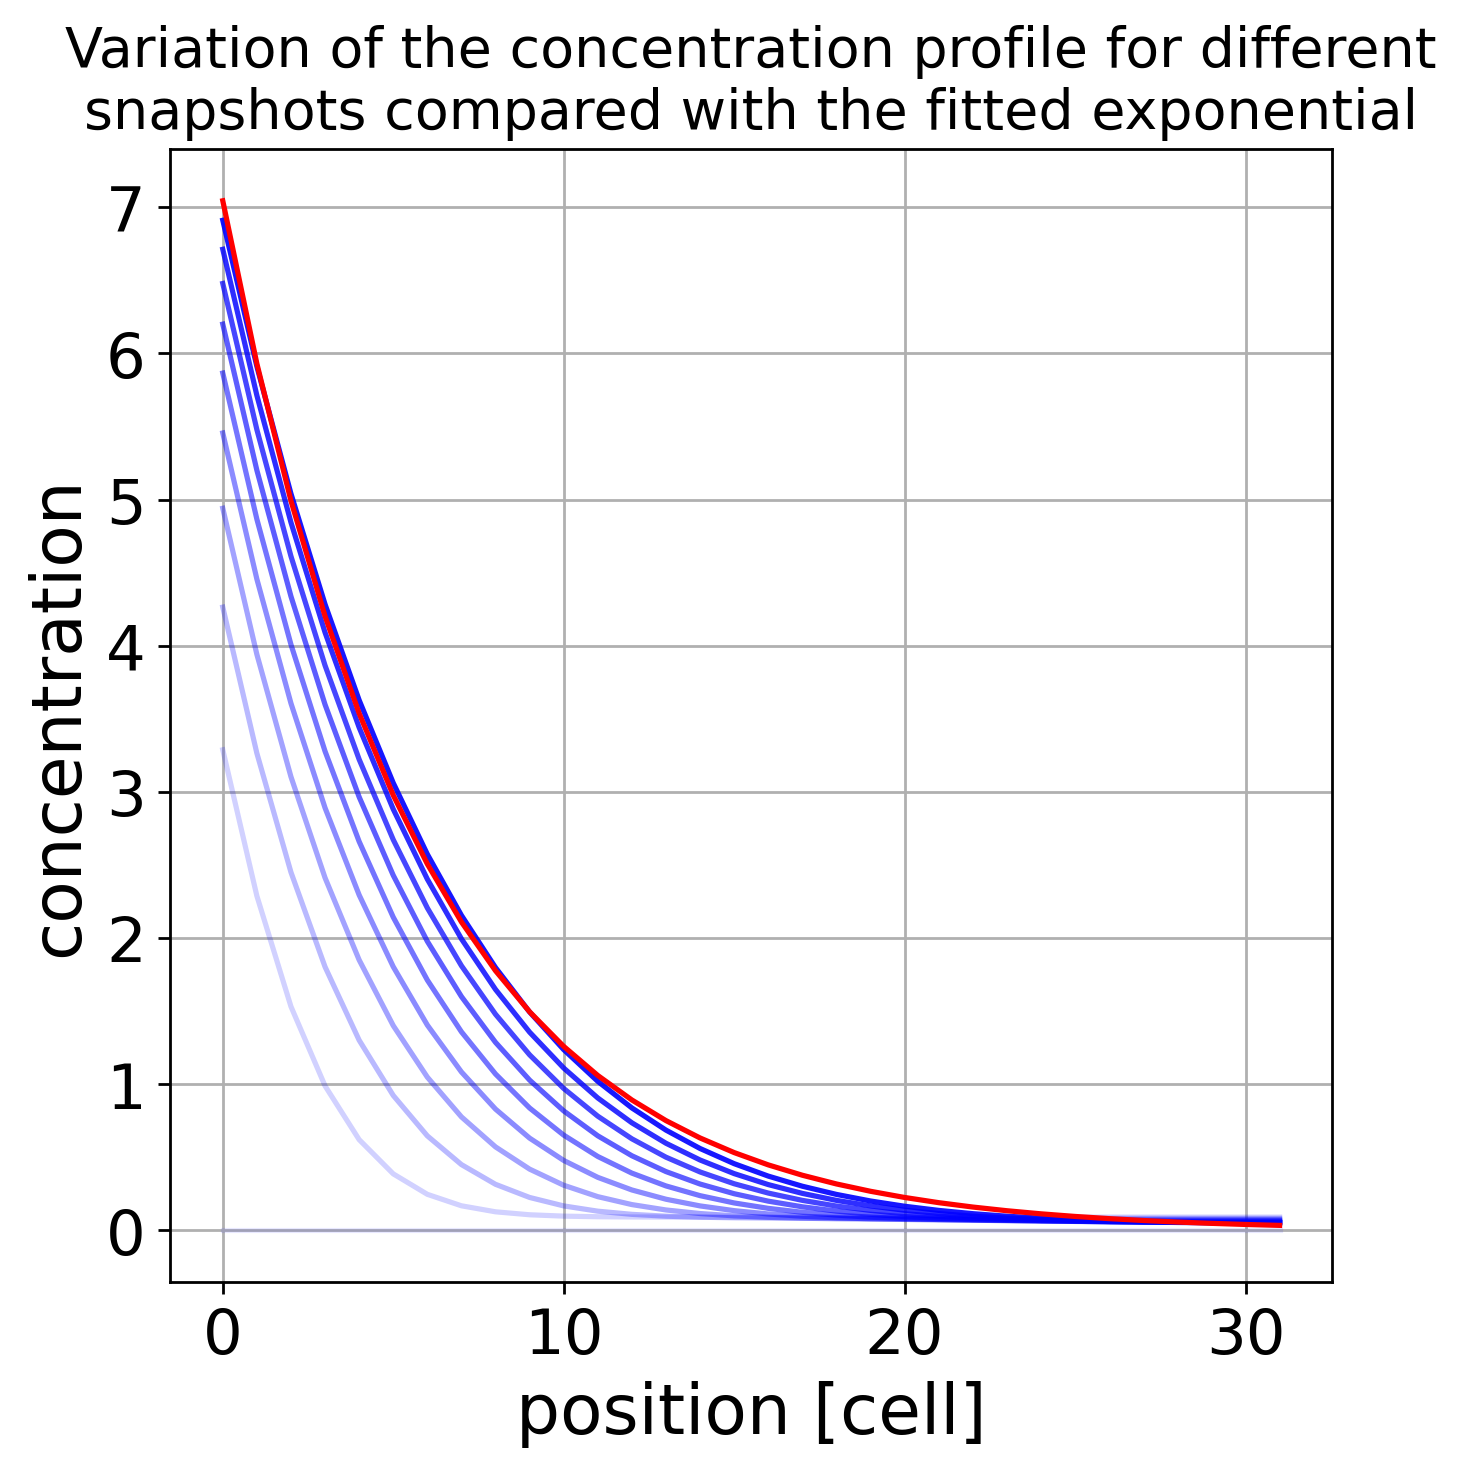

In [7]:
# Compare results to exponential curve
variables = compareToExpectation(xPoints, concHistory[-1], diffConst, decayConst)
# Plots the results
displayConcHistory(xPoints, concHistory, Nspace, Nsteps, dx, dt, numOfSnapshots, variables, snapshotPeriod)